In [4]:
# Stiff Robertson's problem from chemical kinetics as in
# https://archimede.uniba.it/~testset/report/rober.pdf
import numpy as np
import matplotlib.pyplot as plt
import time

a = 0.04
b = 1.0e4
c = 3.0e7

# timestep, Tmax, tolearnce for Newton's solver
h = 1.0e-3
Tmax = 1.0e2 # up to 4.0e10
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# initial condition
y0 = np.array([1.0,0.0,0.0])

# the right-hand side
def func(y):
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac


In [5]:
# DIRK2

def NewtonIterDIRK2(y,h,k,gamma):
    aux = y + h*gamma*k
    F = k - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    gamma = 1.0 - 1.0/np.sqrt(2)
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2(y,h,k1,gamma)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    y = y + h*(1-gamma)*k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2(y,h,k2,gamma)
        aux = y + h*gamma*k2
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux


In [6]:
# solve Robertson's problem

sol = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol[0,:] = y0

start_time = time.time()

method_name = "DIRK2"
for j in range(Nsteps): # DIRK2
    sol[j+1,:] = DIRK2step(sol[j,:],h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'method = {method_name:5}, CPUtime = {t_cpu:.6e}')


method = DIRK2, CPUtime = 8.127986e+00


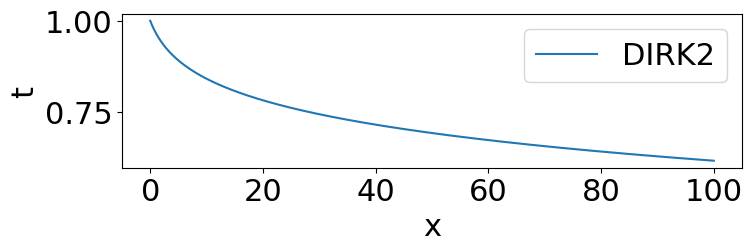

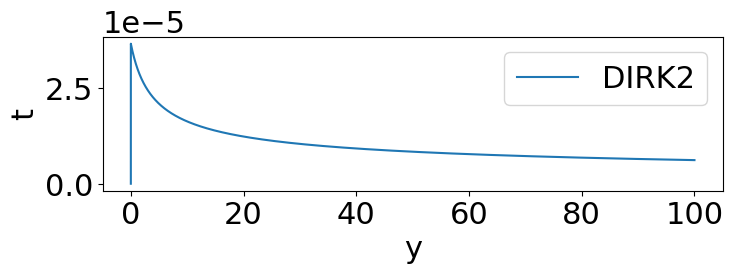

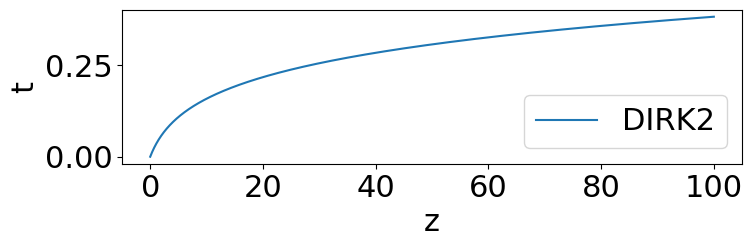

In [7]:
# plot the solution
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,0],label = "DIRK2")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,1],label = "DIRK2")
plt.xlabel("y")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,2],label = "DIRK2")
plt.xlabel("z")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")


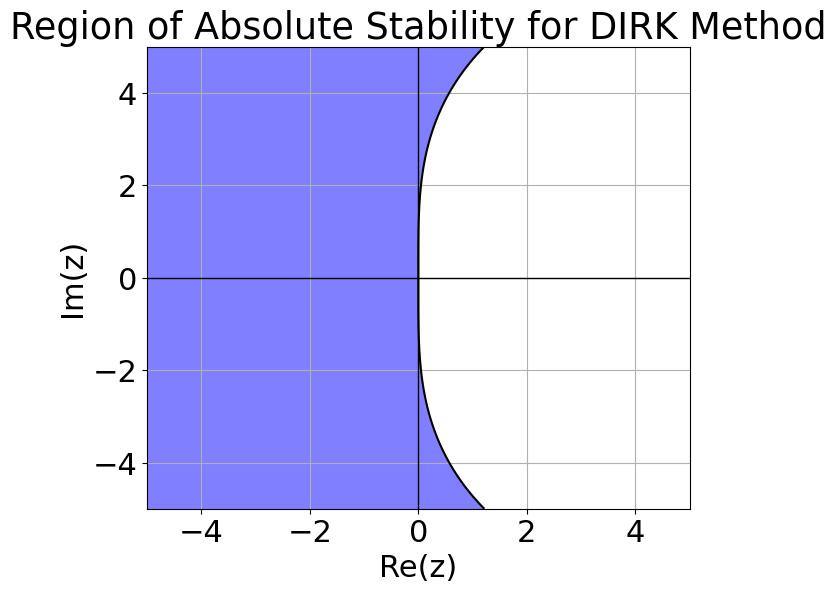

In [8]:
#Problem 2 RAS


# Define gamma
gamma_value = (2 - np.sqrt(2)) / 2

# Define the stability function R(z)
def stability_function(z, gamma):
    return (1 + z - 2 * z * gamma) / ((1 - z * gamma) ** 2)

# Create a grid in the complex plane
x_vals = np.linspace(-5, 5, 400)  # Real part of z
y_vals = np.linspace(-5, 5, 400)  # Imaginary part of z
X, Y = np.meshgrid(x_vals, y_vals)  # Meshgrid for plotting
Z = X + 1j * Y  # Define complex plane values

# Compute the magnitude |R(z)|
R_vals = np.abs(stability_function(Z, gamma_value))

# Plot the region where |R(z)| ≤ 1
plt.figure(figsize=(7, 6))
plt.contourf(X, Y, R_vals, levels=[0, 1], colors=['blue'], alpha=0.5)  # Stability region in blue
plt.contour(X, Y, R_vals, levels=[1], colors='black')  # Boundary where |R(z)| = 1

# Formatting the plot
plt.axhline(0, color='black', linewidth=1)  # x-axis
plt.axvline(0, color='black', linewidth=1)  # y-axis
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title("Region of Absolute Stability for DIRK Method")
plt.grid(True)

# Show the plot
plt.show()



Running simulations with h = 0.001

Running simulations with h = 0.01

Running simulations with h = 0.1


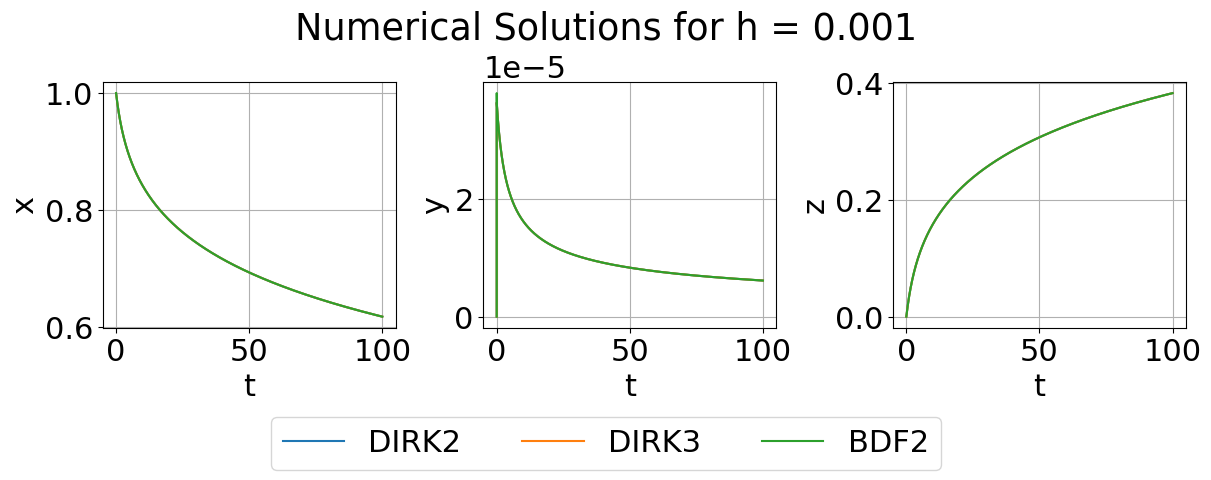

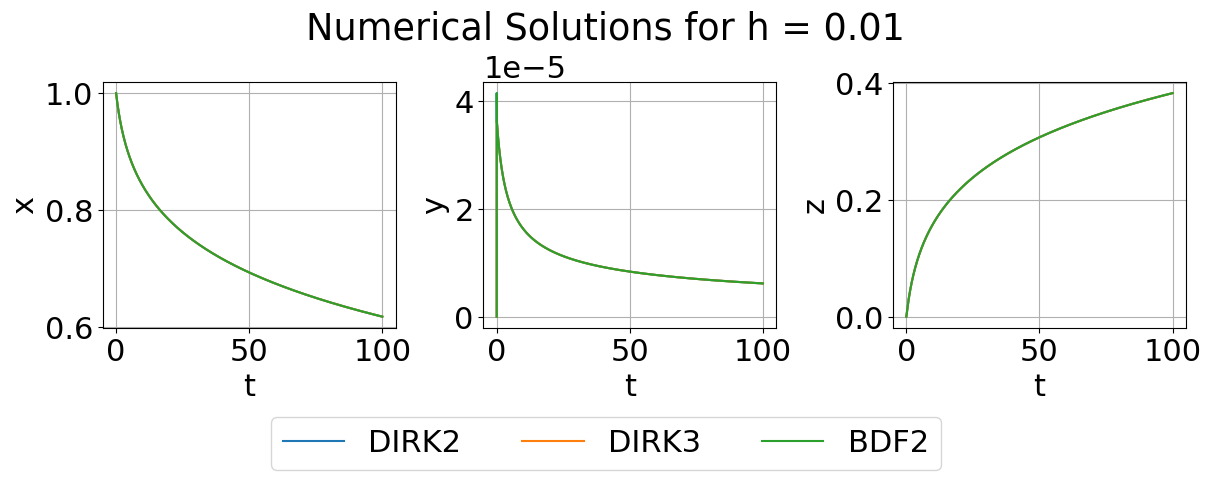

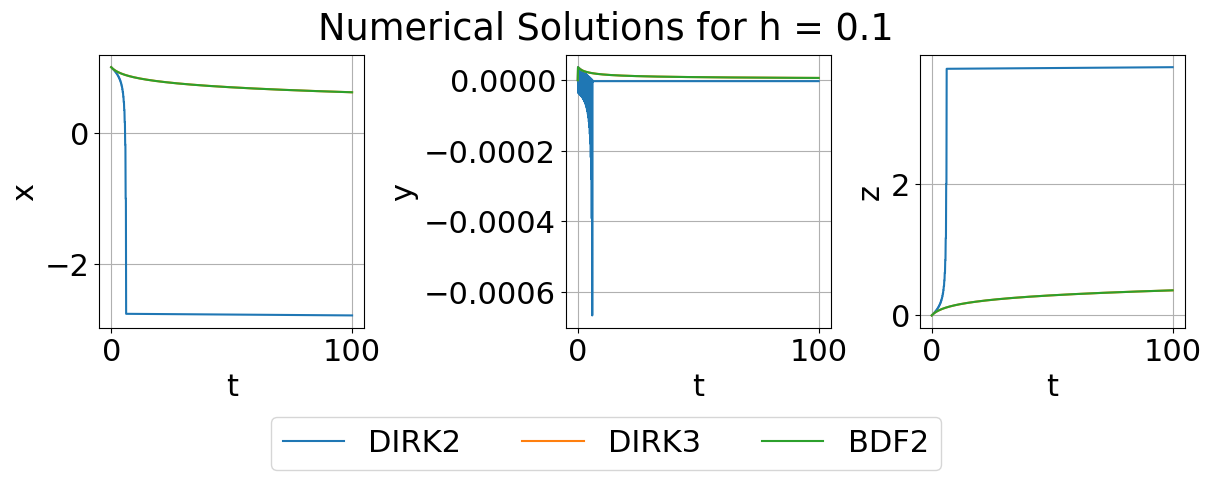

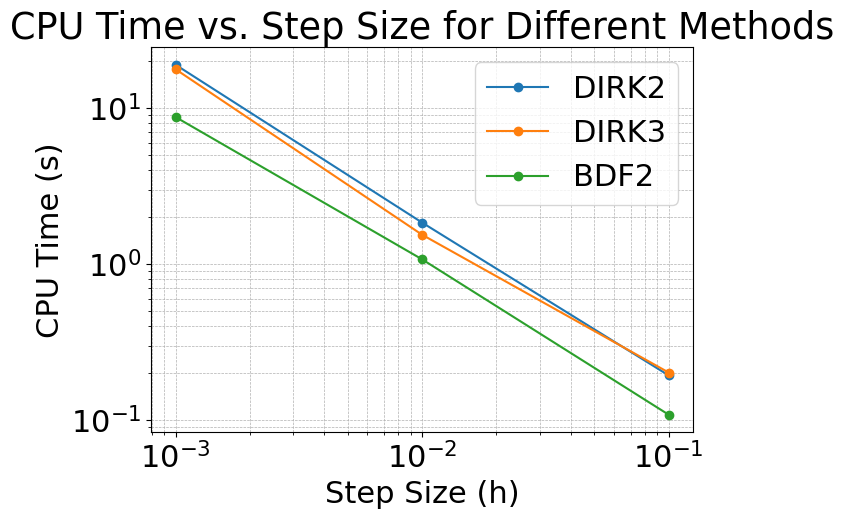

In [22]:
#Problem 3
import numpy as np
import matplotlib.pyplot as plt
import time

# Parameters
a, b, c = 0.04, 1.0e4, 3.0e7
tol = 1.0e-14
itermax = 20
y0 = np.array([1.0, 0.0, 0.0])

# ODE System
def func(y):
    dy = np.zeros(3)
    byz, cy2, ax = b * y[1] * y[2], c * y[1] ** 2, a * y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

def Jac(y):
    by, bz, c2y = b * y[1], b * y[2], 2 * c * y[1]
    J = np.zeros((3, 3))
    J[0, 0], J[0, 1], J[0, 2] = -a, bz, by
    J[1, 0], J[1, 1], J[1, 2] = a, -bz - c2y, -by
    J[2, 1] = c2y
    return J

# Newton Solver
def NewtonIter(y, h, k, gamma=None, method="DIRK"):
    if method == "BDF2":
        F = (3 * k - 4 * y[1] + y[0]) / (2 * h) - func(k)
        DF = (3 / (2 * h)) * np.identity(3) - Jac(k)
    else:
        aux, F = y + h * gamma * k, k - func(y + h * gamma * k)
        DF = np.identity(3) - h * gamma * Jac(aux)
    return k - np.linalg.solve(DF, F)

# DIRK2 & DIRK3
def DIRK_step(y, h, method="DIRK2"):
    gamma = 1.0 - 1.0 / np.sqrt(2) if method == "DIRK2" else 1/2 + np.sqrt(3)/6
    k1 = func(y)
    for _ in range(itermax):
        k1_new = NewtonIter(y, h, k1, gamma, method)
        if np.linalg.norm(k1_new - k1) < tol:
            break
        k1 = k1_new
    k2 = k1
    y = y + h * (1 - gamma) * k1
    for _ in range(itermax):
        k2_new = NewtonIter(y, h, k2, gamma, method)
        if np.linalg.norm(k2_new - k2) < tol:
            break
        k2 = k2_new
    return y + h * gamma * k2

# BDF2
def BDF2(y0, h, Tmax):
    Nsteps = int(np.ceil(Tmax/h))
    sol, t = np.zeros((Nsteps+1, 3)), np.arange(0, (Nsteps+1) * h, h)
    sol[0, :], sol[1, :] = y0, DIRK_step(y0, h, "DIRK2")
    for j in range(1, Nsteps):
        k = sol[j, :]
        for _ in range(itermax):
            k_new = NewtonIter(sol[j-1:j+1], h, k, method="BDF2")
            if np.linalg.norm(k_new - k) < tol:
                break
            k = k_new
        sol[j+1, :] = k
    return t, sol

# Solve Robertson Problem
h_values = [1e-3, 1e-2, 1e-1]
methods = ["DIRK2", "DIRK3", "BDF2"]
cpu_times = {method: [] for method in methods}
results = {}

for h in h_values:
    print(f"\nRunning simulations with h = {h}")
    for method in methods:
        start_time = time.time()

        if method == "BDF2":
            t, sol = BDF2(y0, h, 100)
        else:
            Nsteps = int(np.ceil(100 / h))
            sol = np.zeros((Nsteps + 1, 3))
            sol[0, :] = y0
            t = np.arange(0, (Nsteps + 1) * h, h)
            for j in range(Nsteps):
                sol[j + 1, :] = DIRK_step(sol[j, :], h, method)

        end_time = time.time()
        cpu_times[method].append(end_time - start_time)
        results[(method, h)] = (t, sol)


for h in h_values:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    fig.suptitle(f"Numerical Solutions for h = {h}")

    handles, labels = [], []

    for i, var in enumerate(["x", "y", "z"]):
        for method in methods:
            t, sol = results[(method, h)]
            line, = axes[i].plot(t, sol[:, i], label=f"{method}")
            if i == 0:
                handles.append(line)
                labels.append(f"{method}")

        axes[i].set_xlabel("t")
        axes[i].set_ylabel(var)
        axes[i].grid(True)

    fig.legend(handles, labels, loc="lower center", ncol=len(methods), bbox_to_anchor=(0.5, -0.2))

    plt.show()


# CPU Time Plot
plt.figure(figsize=(7, 5))
for method in methods:
    plt.plot(h_values, cpu_times[method], marker='o', linestyle='-', label=method)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Step Size (h)")
plt.ylabel("CPU Time (s)")
plt.title("CPU Time vs. Step Size for Different Methods")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Method: DIRK2, mu = 1.0e+02, CPU Time: 3.722855e+01


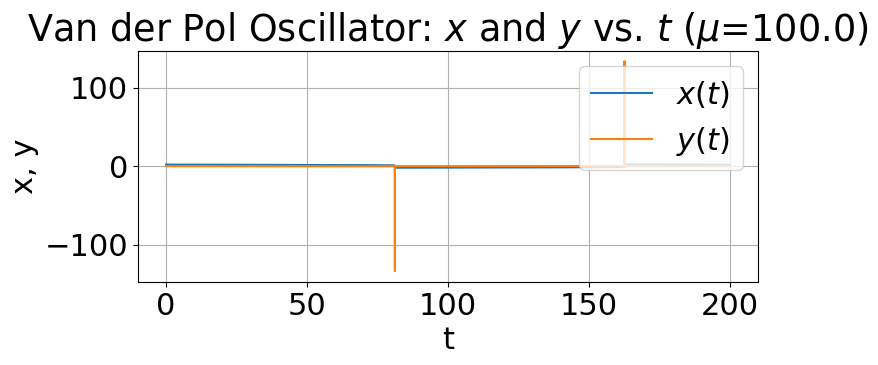

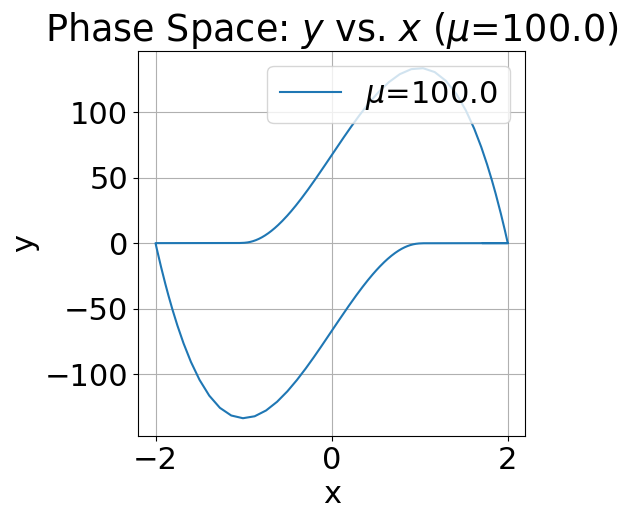

Method: DIRK2, mu = 1.0e+03, CPU Time: 3.703918e+01


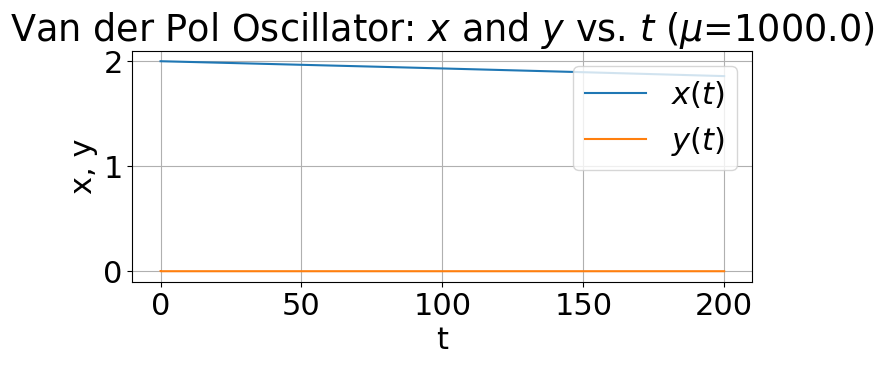

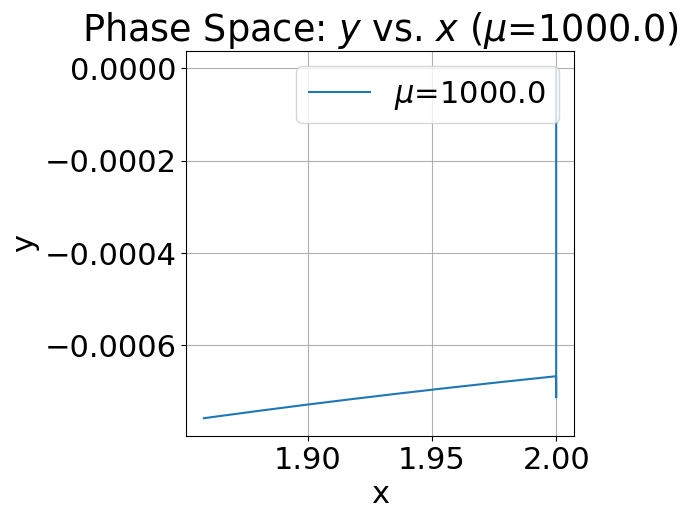

Method: Adaptive DIRK2, mu = 1.0e+06, CPU Time: 3.993021e+00


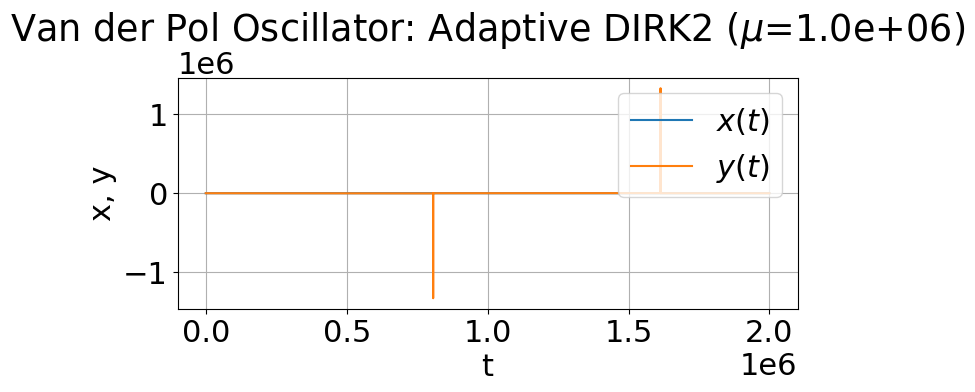

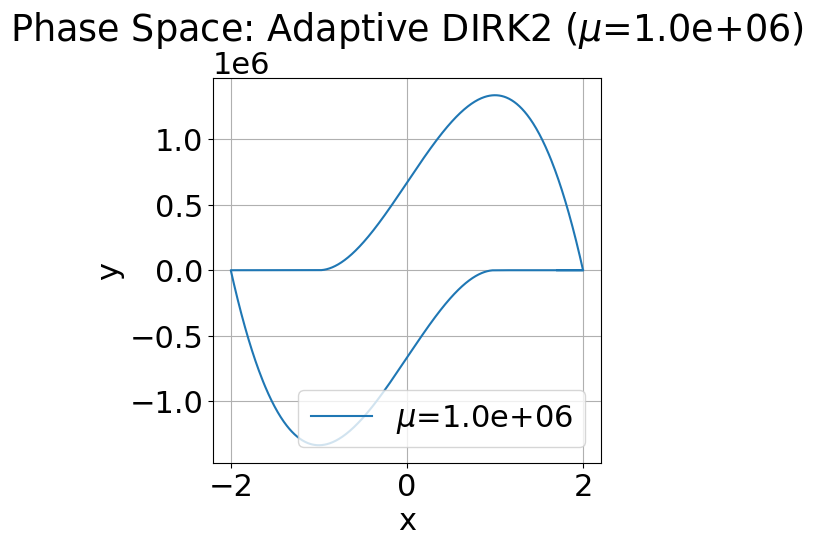

In [23]:
# Problem 4
import numpy as np
import matplotlib.pyplot as plt
import time

def func_vdp(y, mu):
    dy = np.zeros(2)
    dy[0] = y[1]
    dy[1] = mu * (1 - y[0]**2) * y[1] - y[0]
    return dy

def Jac_vdp(y, mu):
    Jac = np.zeros((2,2))
    Jac[0,1] = 1
    Jac[1,0] = -2 * mu * y[0] * y[1] - 1
    Jac[1,1] = mu * (1 - y[0]**2)
    return Jac

def DIRK2_step_vdp(y, h, func, Jac, mu, gamma=1 - 1/np.sqrt(2)):
    k1 = func(y, mu)
    for _ in range(20):
        k1_new = k1 - np.linalg.solve(np.identity(2) - h * gamma * Jac(y + h * gamma * k1, mu),
                                      k1 - func(y + h * gamma * k1, mu))
        if np.linalg.norm(k1_new - k1) < 1e-14:
            break
        k1 = k1_new

    k2 = k1
    y_new = y + h * (1 - gamma) * k1
    for _ in range(20):
        k2_new = k2 - np.linalg.solve(np.identity(2) - h * gamma * Jac(y_new + h * gamma * k2, mu),
                                      k2 - func(y_new + h * gamma * k2, mu))
        if np.linalg.norm(k2_new - k2) < 1e-14:
            break
        k2 = k2_new

    return y_new + h * gamma * k2

def Adaptive_DIRK2_step(y, h, func, Jac, mu, gamma=1 - 1/np.sqrt(2)):
    k1 = func(y, mu)
    for _ in range(20):
        k1_new = k1 - np.linalg.solve(np.identity(2) - h * gamma * Jac(y + h * gamma * k1, mu),
                                      k1 - func(y + h * gamma * k1, mu))
        if np.linalg.norm(k1_new - k1) < 1e-14:
            break
        k1 = k1_new

    k2 = k1
    y_intermediate = y + h * (1 - gamma) * k1
    for _ in range(20):
        k2_new = k2 - np.linalg.solve(np.identity(2) - h * gamma * Jac(y_intermediate + h * gamma * k2, mu),
                                      k2 - func(y_intermediate + h * gamma * k2, mu))
        if np.linalg.norm(k2_new - k2) < 1e-14:
            break
        k2 = k2_new

    y_new = y_intermediate + h * gamma * k2
    b_1st_order = np.array([1 - 2 * gamma, 2 * gamma])
    y_low = y + h * (b_1st_order[0] * k1 + b_1st_order[1] * k2)
    e = y_new - y_low

    atol, rtol, safety_factor = 1e-5, 1e-5, 0.9
    min_reduction, max_growth = 0.2, 5.0
    tol_threshold = atol + rtol * np.linalg.norm(y_new)
    error_norm = max(np.linalg.norm(e), 1e-14)
    h_new = h * np.clip((tol_threshold / error_norm) ** 0.25, min_reduction, max_growth) * safety_factor

    return y_new, h_new, np.linalg.norm(e)

def simulate_vdp(mu, Tmax, h, adaptive=False):
    y0 = np.array([2.0, 0.0])
    t_values, y_values, h_values = [0], [y0], [h]

    start_time = time.time()
    t, y = 0, y0

    while t < Tmax:
        if t + h > Tmax:
            h = Tmax - t

        if adaptive:
            y, h_new, _ = Adaptive_DIRK2_step(y, h, func_vdp, Jac_vdp, mu)
            h_values.append(h_new)
        else:
            y = DIRK2_step_vdp(y, h, func_vdp, Jac_vdp, mu)

        t += h
        t_values.append(t)
        y_values.append(y)
        h = h_new if adaptive else h

    end_time = time.time()
    print(f"Method: {'Adaptive DIRK2' if adaptive else 'DIRK2'}, mu = {mu:.1e}, CPU Time: {end_time - start_time:.6e}")

    return np.array(t_values), np.array(y_values)

mu_values_fixed = [1e2, 1e3]
mu_adaptive = 1e6
Tmax_fixed, Tmax_adaptive = 200, 2e6
h_fixed, h_adaptive = 1e-3, 1e-3

for mu in mu_values_fixed:
    t_fixed, y_fixed = simulate_vdp(mu, Tmax_fixed, h_fixed)

    plt.figure(figsize=(8, 3))
    plt.plot(t_fixed, y_fixed[:, 0], label=r"$x(t)$")
    plt.plot(t_fixed, y_fixed[:, 1], label=r"$y(t)$")
    plt.xlabel("t")
    plt.ylabel("x, y")
    plt.title(f"Van der Pol Oscillator: $x$ and $y$ vs. $t$ ($\mu$={mu})")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.plot(y_fixed[:, 0], y_fixed[:, 1], label=f"$\mu$={mu}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Phase Space: $y$ vs. $x$ ($\mu$={mu})")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

t_adaptive, y_adaptive = simulate_vdp(mu_adaptive, Tmax_adaptive, h_adaptive, adaptive=True)

plt.figure(figsize=(8, 3))
plt.plot(t_adaptive, y_adaptive[:, 0], label=r"$x(t)$")
plt.plot(t_adaptive, y_adaptive[:, 1], label=r"$y(t)$")
plt.xlabel("t")
plt.ylabel("x, y")
plt.title(f"Van der Pol Oscillator: Adaptive DIRK2 ($\mu$={mu_adaptive:.1e})")
plt.legend(loc="upper right")
plt.grid()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(y_adaptive[:, 0], y_adaptive[:, 1], label=f"$\mu$={mu_adaptive:.1e}")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Phase Space: Adaptive DIRK2 ($\mu$={mu_adaptive:.1e})")
plt.legend(loc="lower right")
plt.grid()
plt.show()
